# Report

---
# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkb

from dotenv import load_dotenv
import awswrangler as wr
import os
import yaml
import boto3

In [87]:
# load environment variables with
load_dotenv()

# import config
with open("../config.yaml") as f:
    config = yaml.safe_load(f)

# connect to AWS with credentials
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("REGION")
BUCKET = os.getenv("BUCKET")
FOLDER = config["aws"]["folder"]

# connect to AWS
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)
s3 = session.client("s3")

---
# Data

## Users

In [9]:
# get data from S3
gdf_users = (
    wr.s3.read_parquet(
        f"s3://{BUCKET}/{FOLDER}/{config['aws']['users-file']}"
    )
    .rename(columns={"client_latitude": "latitude", "client_longitude": "longitude"})
    # convert to GeoDataFrame
    .pipe(gpd.GeoDataFrame)
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude'], x['latitude'])
    )
    .set_crs(epsg=4326)
)
gdf_users.head()

/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by promote_options='default'.
  return cls.dispatch_func(func)(*args, **kw)
/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/pandas/core/frame.py:5226: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


,device_id,postal_code,raw_sim_operator_name,longitude,latitude,geometry
0,436672830.0,47472,BAIT,-101.961,21.333,POINT (-101.96100 21.33300)
1,464809820.0,27087,Mega4.5G,-103.331,25.539,POINT (-103.33100 25.53900)
2,434158753.0,29454,Sin servicio,-92.275,16.845,POINT (-92.27500 16.84500)
3,409155526.0,57750,BAIT,-99.025,19.387,POINT (-99.02500 19.38700)
4,456104373.0,30190,BAIT,-92.038,16.735,POINT (-92.03800 16.73500)


In [194]:
# count of raw_sim_operator_name
gdf_users["raw_sim_operator_name"].value_counts()

raw_sim_operator_name
BAIT                     31822
TELCEL                    2626
Mega 4.5G                 2306
NeWWW                     2194
izzi                      1834
                         ...  
CFE TEIT R | CFE TEIT        1
(No hay servicio)            1
Searching for Service        1
mmmm                         1
Verizon                      1
Name: count, Length: 339, dtype: Int64

In [145]:
gdf_users.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59961 entries, 0 to 59960
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   device_id              59961 non-null  float64 
 1   postal_code            59961 non-null  string  
 2   raw_sim_operator_name  59961 non-null  string  
 3   longitude              59961 non-null  float64 
 4   latitude               59961 non-null  float64 
 5   geometry               59961 non-null  geometry
dtypes: float64(3), geometry(1), string(2)
memory usage: 2.7 MB


<Axes: >

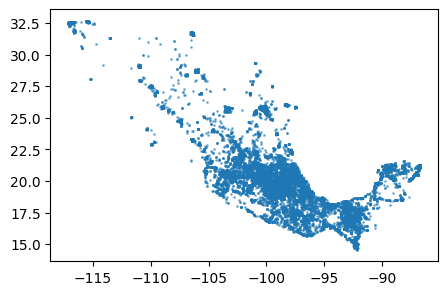

In [15]:
gdf_users.plot(
    figsize=(5, 5),
    alpha=0.5,
    markersize=1
)

## Stores

In [141]:
# get walmart
re_walmart = r"(walmart|wal mart|superama|waltmart)"
re_sams = r"(sams|sam's|sam s|sam's club|sam s club|sam'sclub|sam sclub|sam club|mi bodega)"
re_bodega = r"(bodega aurrera|bodega|aurrera|ba|boa|\$b|mb|b )"
re_supercenter = r"(supercenter|super center)"

gdf_walmart = (
    wr.s3.read_csv(
        f"s3://{BUCKET}/{FOLDER}/{config['aws']['walmart-file']}"
    )
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude'], x['latitude']),
        # get bodega aurrera or walmart or sams in name
        store_name=lambda x: np.select(
            [
                x['name'].str.contains(re_bodega, case=False),
                x['name'].str.contains(re_walmart, case=False),
                x['name'].str.contains(re_sams, case=False),
                x['name'].str.contains(re_supercenter, case=False)
            ],
            ['bodega aurrera', 'walmart', 'sams', 'supercenter'],
            default='other'
        )
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:4326")
    .query("store_name != 'other'")
    .loc[:, [
             'id', 'store_name', 'name', 'staff_stratum_description',
             'postal_code', 'cve_ent', 'cve_mun', 'geometry'
            ]]
)
gdf_walmart.head()

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/4058890144.py:16: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/4058890144.py:17: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/4058890144.py:18: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/4058890144.py:19: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,id,store_name,name,staff_stratum_description,postal_code,cve_ent,cve_mun,geometry
0,1263973,bodega aurrera,BODEGA AURRERA PENAFLOR 1253,101 a 250 personas,76116,22,14,POINT (-100.47861 20.64249)
1,1263981,bodega aurrera,BODEGA AURRERA EXPRESS MISION QUERETARO 3404,6 a 10 personas,76116,22,14,POINT (-100.46298 20.64603)
2,1263982,bodega aurrera,BODEGA AURRERA EXPRESS SAN PEDRO 2978,11 a 30 personas,76113,22,14,POINT (-100.46554 20.61523)
3,1263983,bodega aurrera,BODEGA AURRERA,0 a 5 personas,76010,22,14,POINT (-100.42465 20.58914)
4,1263987,bodega aurrera,BODEGA AURRERA BELEN 2554,11 a 30 personas,76148,22,14,POINT (-100.39423 20.64687)


In [77]:
# count stores
gdf_walmart['store_name'].value_counts()

store_name
bodega aurrera    2061
supercenter        251
sams               150
walmart            136
Name: count, dtype: int64

<Axes: >

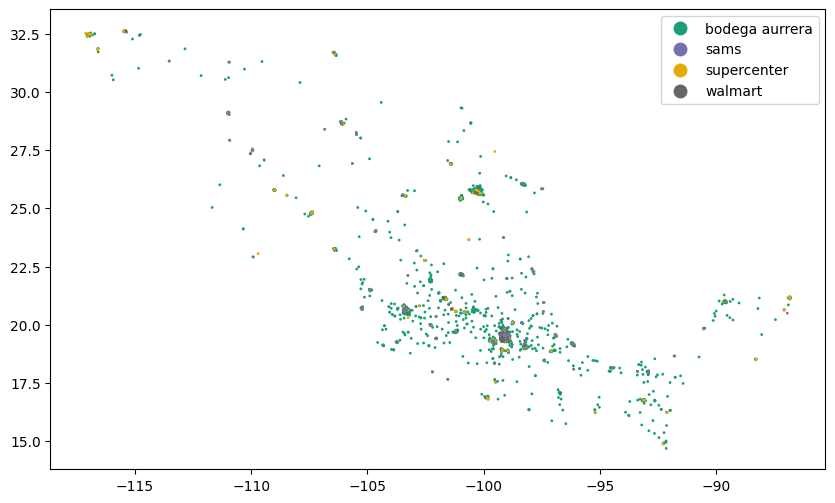

In [85]:
# plot stores by store name
gdf_walmart.plot(
    figsize=(10, 10),
    markersize=1,
    column='store_name',
    legend=True,
    cmap='Dark2'
)

## Inegi States

In [185]:
# download shapefile of states
gdf_states = (
    wr.s3.read_parquet(
        "s3://itam-analytics-javier/telecom-outputs/mexico_states.parquet"
    )
    # pass geometry column from binary to geometry
    .assign(geometry=lambda x: x['geometry'].apply(wkb.loads))
    .pipe(gpd.GeoDataFrame)
    .set_crs(epsg=4326)
    .rename(columns={"CODIGO": "cve_ent", "ESTADO": "cve_name"})
    .assign(
        cve_ent=lambda x: x['cve_ent'].str[-2:],
        cve_name=lambda x: x['cve_name'].str.lower()
    )
    .sort_values('cve_ent', ignore_index=True)
)
gdf_states.head()

/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/awswrangler/_distributed.py:104: FutureWarning:

promote has been superseded by promote_options='default'.



,cve_ent,cve_name,geometry
0,01,aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."
1,02,baja california,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
2,03,baja california sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
3,04,campeche,"MULTIPOLYGON (((-91.83446 18.63805, -91.84195 ..."
4,05,chiapas,"POLYGON ((-91.43750 17.24111, -91.35278 17.176..."


<Axes: >

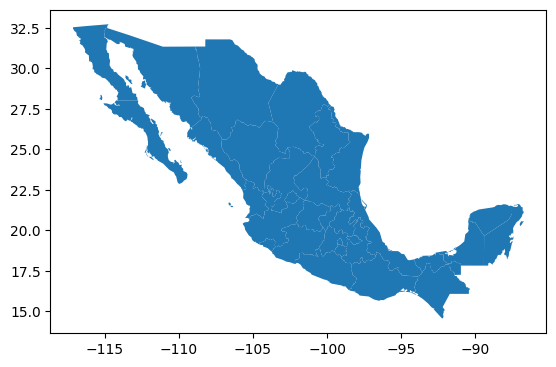

In [128]:
gdf_states.plot()

---
# Analysis

## Attribution

In [175]:
# join users with stores getting the closest store
gdf_store_attr = (
    gpd.sjoin_nearest(
        gdf_users.to_crs("EPSG:6372"), gdf_walmart.to_crs("EPSG:6372"),
    )
    .drop_duplicates(subset=["device_id"])
    .groupby(["name", "store_name", "id", "cve_ent", "cve_mun"])  # denue_id is the store id
    .agg(
        count=("device_id", "count")
    )
    .reset_index()
    .sort_values("count", ascending=False)
    .merge(
        gdf_walmart.loc[:, ["id", "geometry"]],
        on="id",
        how="left"
    )
    .pipe(gpd.GeoDataFrame)
    .set_crs(epsg=4326)
)
gdf_store_attr

,name,store_name,id,cve_ent,cve_mun,count,geometry
0,BODEGA AURRERA NAHIL 2476,bodega aurrera,1271843,23,5,227,POINT (-86.90944 21.15259)
1,BODEGA PEDRO RAMIREZ 1853,bodega aurrera,917764,9,13,192,POINT (-99.10695 19.25704)
2,MI BODEGA IXTLAHUACA 1194,bodega aurrera,1101847,15,42,190,POINT (-99.76479 19.56857)
3,BODEGA CIUDAD INDUSTRIAL 1101,bodega aurrera,1302589,27,4,181,POINT (-92.90995 18.01787)
4,MI BODEGA PLUTARCO ELIAS CALLES 1729,bodega aurrera,983254,11,32,164,POINT (-100.38048 21.00484)
...,...,...,...,...,...,...,...
2528,SUPERCENTER VALLARTA 2342,supercenter,1050977,14,120,1,POINT (-103.43102 20.68071)
2529,BA EXPRESS BOSQUES DE MEXICO 1566,bodega aurrera,1069018,15,33,1,POINT (-99.02830 19.61078)
2530,SAMS PLAZA ARAGON 6247,sams,1139525,15,33,1,POINT (-99.02851 19.53134)
2531,MI BODEGA LAZARO GUTIERREZ 2247,bodega aurrera,1300730,26,19,1,POINT (-110.28819 30.98702)


<Axes: >

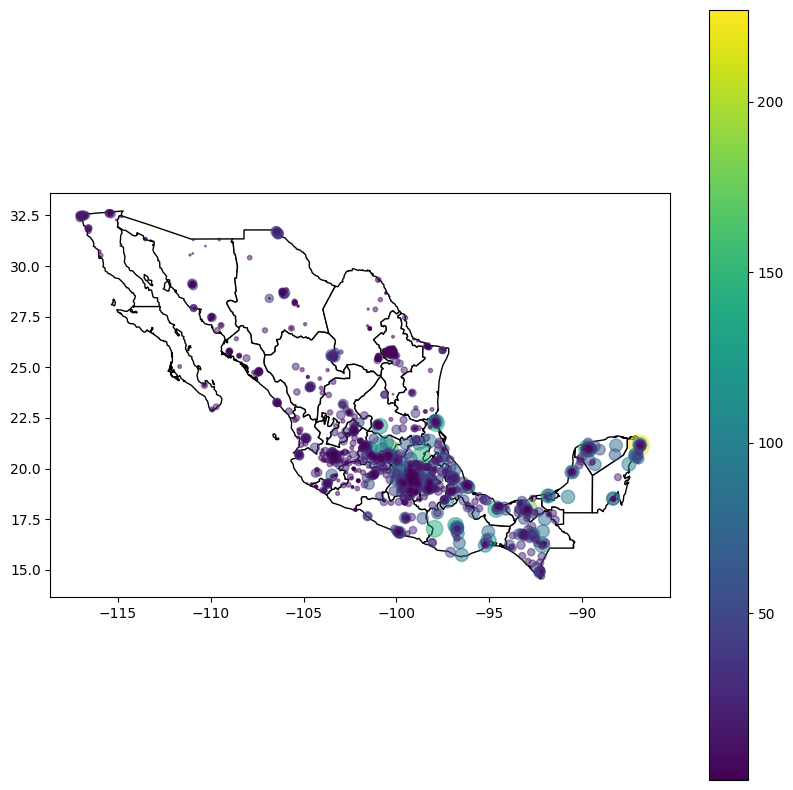

In [177]:
# plot stores with count of users
fig, ax = plt.subplots(figsize=(10, 10))
gdf_states.plot(ax=ax, color='white', edgecolor='black')
gdf_store_attr.plot(
    ax=ax,
    markersize=gdf_store_attr['count'],
    column='count',
    legend=True,
    cmap='viridis',
    alpha=0.5
)

In [190]:
# join users with states
gdf_state_attr = (
    gpd.sjoin_nearest(
        gdf_users.to_crs("EPSG:6372"), gdf_states.to_crs("EPSG:6372"),
    )
    .drop_duplicates(subset=["device_id"])
    .groupby(["cve_ent", "cve_name"])  # denue_id is the store id
    .agg(
        count=("cve_ent", "count")
    )
    .reset_index()
    .sort_values("count", ascending=False)
    .merge(
        gdf_states.loc[:, ["cve_ent", "geometry"]],
        on="cve_ent",
        how="left"
    )
    .pipe(gpd.GeoDataFrame)
    .set_crs(epsg=4326)
)

gdf_state_attr

,cve_ent,cve_name,count,geometry
0,15,méxico,12624,"POLYGON ((-98.62798 19.47576, -98.66612 19.405..."
1,09,distrito federal,7369,"POLYGON ((-99.28487 19.14244, -99.34056 19.357..."
2,14,jalisco,4347,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
3,30,veracruz,3379,"POLYGON ((-93.58940 17.37546, -93.62695 17.307..."
4,21,puebla,2675,"POLYGON ((-96.75063 18.43083, -96.72639 18.385..."
5,11,guanajuato,2616,"POLYGON ((-100.28030 20.20451, -100.34860 20.0..."
6,19,nuevo león,2492,"POLYGON ((-99.71816 27.66586, -99.91585 27.523..."
7,05,chiapas,2276,"POLYGON ((-91.43750 17.24111, -91.35278 17.176..."
8,20,oaxaca,1891,"POLYGON ((-96.75063 18.43083, -96.63556 18.522..."
9,22,querétaro,1844,"POLYGON ((-100.12280 19.93804, -100.18250 20.0..."


<Axes: >

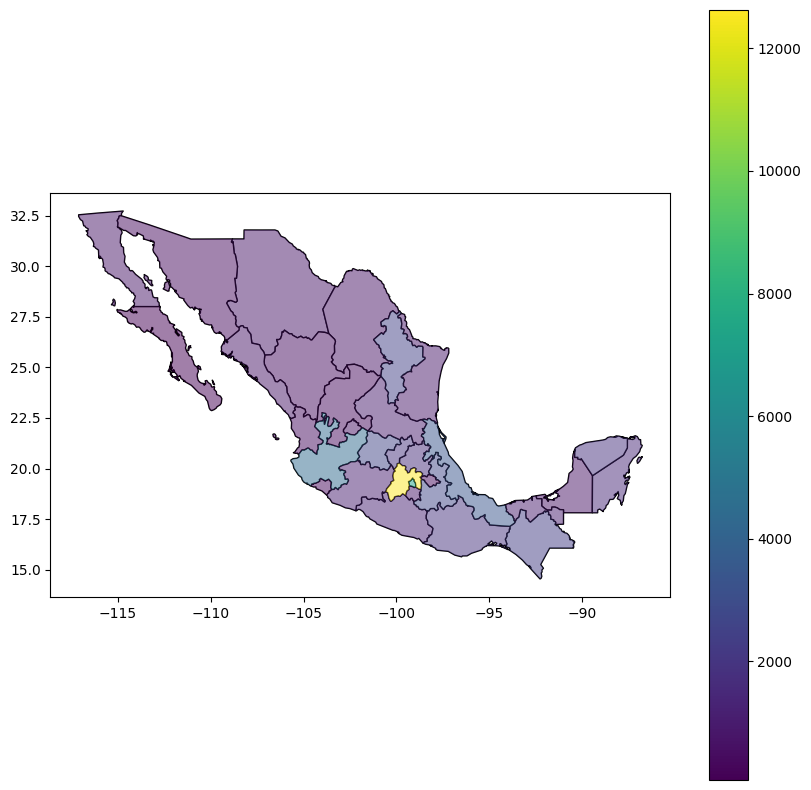

In [191]:
# plot states with count of users
fig, ax = plt.subplots(figsize=(10, 10))
gdf_states.plot(ax=ax, color='white', edgecolor='black')

gdf_state_attr.plot(
    ax=ax,
    markersize=gdf_state_attr['count'],
    column='count',
    legend=True,
    cmap='viridis',
    alpha=0.5
)

---
# EDA

In [100]:
import plotly.express as px